In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import preprocessing

In [3]:
#Select the Store and Version of Clustered Data
Store = 34
data = pd.read_csv('Store'+str(Store)+'\Store'+str(Store)+'_variable+15min-cluster.csv',index_col=0) #15min-cluster or 30min-cluster
data['BusinessDate'] = pd.to_datetime(data['BusinessDate'])
#Specify Date-Time Variable Types
date_time = ['OrderStartDateTime','NormalDateTime','BumpedDateTime','CookingDateTime','DayHalfHour','DayQuarterHour']
for i in date_time:
    data.loc[:,i] = pd.to_datetime(data.loc[:,i], format="%Y-%m-%d %H:%M:%S.%f")

In [4]:
data.shape

(960934, 64)

In [5]:
data.columns 

Index(['StoreKey', 'BusinessDate', 'DateKey', 'DayOfWeek', 'TimeKey',
       'FullHour', 'HalfHour', 'QuarterHour', 'StartTime', 'Holiday',
       'CheckNum', 'GuestCount', 'TableOpenMinutes', 'OpenHour', 'OpenMinute',
       'CloseHour', 'CloseMinute', 'ChannelKey', 'TypeofServiceNum',
       'ProductKey', 'CourseName', 'IXIName', 'MajorCodeName', 'MinorCodeName',
       'StationKey', 'StationName', 'SentTime', 'OrderStartDateTime',
       'NormalDateTime', 'CookingDateTime', 'BumpedDateTime', 'NatHolidayDesc',
       'EmployeeKey', 'TicketTime', 'RNK', 'PROD_RNK', 'ORDER_RNK',
       'TypeofServiceCat', 'ChannelName', 'StartTime.1', 'OffSiteOrder',
       'OnSiteOrder', 'TotalOrder', 'OnSiteItem', 'OffSiteItem', 'TotalItem',
       'HalfHourStart', 'Hour', 'DayHalfHour', 'DayQuarterHour',
       'DayOfWeekName', 'Week', 'Weekday', 'OrderTimeMin',
       'BumpedDateTime_fill', 'OpenDateTime', 'CloseDateTime',
       'OnSiteOrder_fill', 'OffSiteOrder_fill', 'OnSiteItem_fill',
       'O

In [5]:
#e = data['EmployeeKey'].value_counts().index[0:10]
#for i in e:
#    data[data['EmployeeKey']==i].boxplot('TicketTime',by=['DayOfWeek','Hour'],figsize=(20,3)) 
#    plt.title('Ticket Time by Product: '+str(i))

# Item per Guest

In [6]:
#data['ItemPerGuest'] = data['GuestEst'] / data['GuestCount']

In [7]:
#data = data[(data['ItemPerGuest']>=0.1)&(data['ItemPerGuest']<=10)]

# Remove Non-Entree Item

In [6]:
#Remove Items sold less than 100 times
data = data[data['ProductKey'].isin(list(data['ProductKey'].value_counts()[data['ProductKey'].value_counts()>=100].index))]

In [7]:
data.shape

(960934, 64)

In [8]:
#Remove None ENTREE Item & Modifiers Item
data = data[data['MajorCodeName'].isin(['APPETIZERS','Appetizers'])==False]
data = data[data['MinorCodeName'].isin(['MODIFIERS'])==False]

In [9]:
data.shape

(847572, 64)

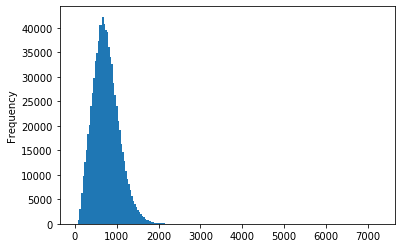

In [10]:
#Ticket Time Distribution Overview
data['TicketTime'].plot(kind='hist',bins=200) 

## Group by Product & Time

In [13]:
#Examine distributions of each item during time period

#p = data['ProductKey'].value_counts().index[0:30]
#t = data['Hour'].value_counts().index[0:8]

#for i in p: 
#    for j in t:
#        if sum((data['ProductKey']==i)&(data['Hour']==j))>=200: 
#            plt.figure()
#            data[(data['ProductKey']==i)&(data['Hour']==j)]['TicketTime'].plot(kind='hist',title=str(i)+' '+str(j),bins=150)


In [14]:
#Examine distributions of each item
#p = list(d['ProductKey'].value_counts().index[0:50]) +list(d['ProductKey'].value_counts().index[-50:-1])

#for i in p: 
#    plt.figure()
#    d[(d['ProductKey']==i)]['TicketTime'].plot(kind='hist',title=i,bins=120)


In [15]:
#Examine distributions of each item during time period

#p = d['ProductKey'].value_counts().index[0:100]
#t = d['Hour'].value_counts().index[0:20]

#for i in p: 
#    for j in t:
#        if sum((d['ProductKey']==i)&(d['Hour']==j))>=200: 
#            plt.figure()
#            d[(d['ProductKey']==i)&(d['Hour']==j)]['TicketTime'].plot(kind='hist',title='Product '+str(i)+': '+'Hour '+str(j),bins=150)


# Aggregate to Order Level

In [11]:
order = data.sort_values(by=['BumpedDateTime'],ascending=False).\
drop_duplicates(subset=['BusinessDate','StoreKey','CheckNum','OrderTimeMin'], keep='first') 
order['OrderTime'] = (order['BumpedDateTime'] - order['OrderStartDateTime']).dt.seconds
order['OrderTime-Min'] = order['OrderTime']/60

In [12]:
order.shape

(398108, 66)

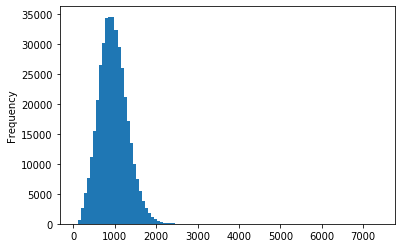

In [13]:
order['OrderTime'].plot(kind='hist',bins=100)

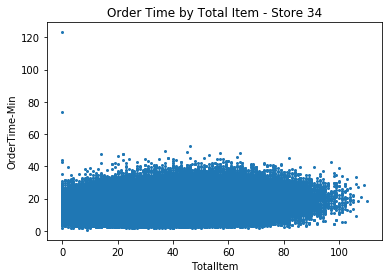

In [14]:
order.plot(x='TotalItem',y='OrderTime-Min',kind='scatter',s=4,title='Order Time by Total Item - Store '+str(Store))

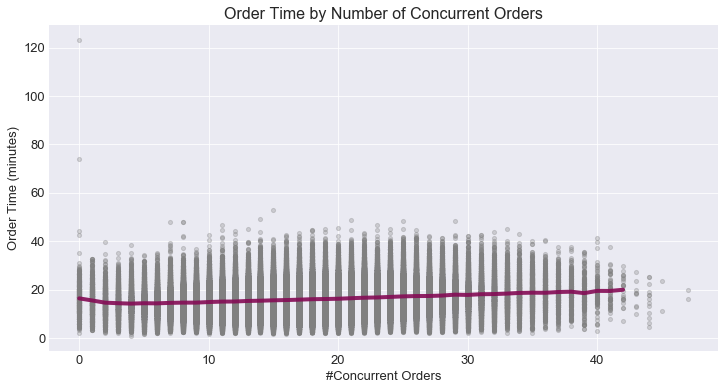

In [15]:
#Order Time by Total Order
plt.style.use('seaborn-dark')
plt.figure(figsize=(12,6))
plt.scatter(order['TotalOrder'], order['OrderTime-Min'],s=17,alpha=0.3,color='grey')
d = order.groupby(['TotalOrder']).agg({'OrderTime-Min':['mean','count']}).reset_index()
d = d[d['OrderTime-Min','count']>20]
plt.plot(d['TotalOrder'],d[('OrderTime-Min','mean')],linewidth=4,alpha = 0.9,color='#840b55')
#plt.plot(order.groupby(['TotalOrder'])['OrderTime-Min'].median(),linewidth=4,alpha = 0.9,color='#840b55')
plt.title('Order Time by Number of Concurrent Orders',family='sans-serif',fontsize=16)
plt.ylabel('Order Time (minutes)',family='sans-serif',fontsize=13)
plt.xlabel('#Concurrent Orders',fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid()


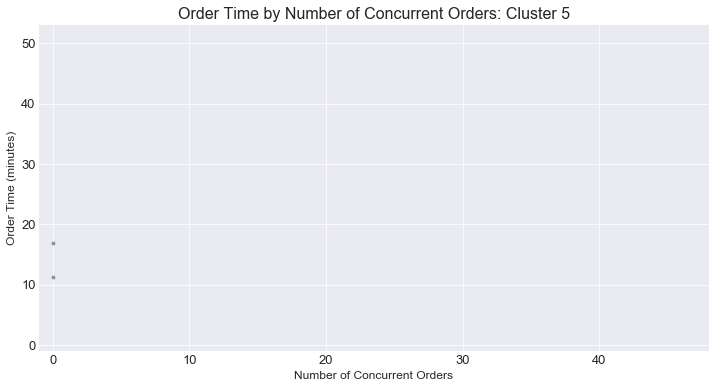

In [16]:
#Order Time by Total Order during the busiest time
c=5
plt.style.use('seaborn-dark')
plt.figure(figsize=(12,6))
plt.scatter(order[order['Class']==c]['TotalOrder'], order[order['Class']==c]['OrderTime-Min'],s=8,alpha=0.8,color='grey')
d = order[order['Class']==c].groupby(['TotalOrder']).agg({'OrderTime-Min':['mean','count']}).reset_index()
d = d[d['OrderTime-Min','count']>18]
plt.plot(d['TotalOrder'],d[('OrderTime-Min','mean')],linewidth=4,alpha = 0.9,color='#840b55')
#plt.plot(order[order['Class']==c].groupby(['TotalOrder'])['OrderTime-Min'].mean(),linewidth=4,alpha = 0.9,color='#840b55')
plt.title('Order Time by Number of Concurrent Orders: Cluster '+str(c),family='sans-serif',fontsize=16)
plt.ylabel('Order Time (minutes)',family='sans-serif',fontsize=12)
plt.xlabel('Number of Concurrent Orders',fontsize=12)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylim(-1,53)
plt.xlim(-1,48)
plt.grid()


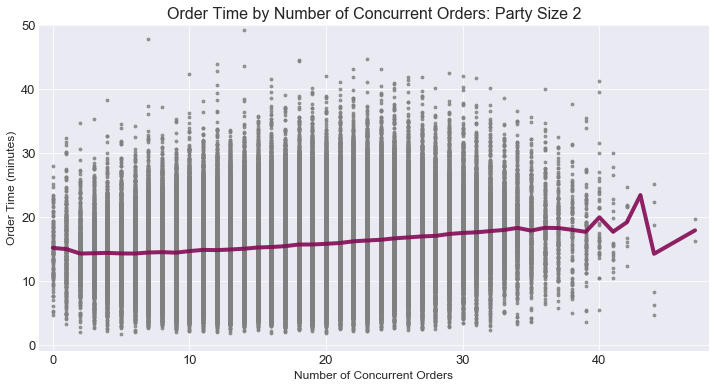

In [17]:
#Order Time by Total Order during the busiest time
p=2
plt.style.use('seaborn-dark')
plt.figure(figsize=(12,6))
plt.scatter(order[order['GuestCount']==p]['TotalOrder'], order[order['GuestCount']==p]['OrderTime-Min'],s=8,alpha=0.8,color='grey')


plt.plot(order[order['GuestCount']==p].groupby(['TotalOrder'])['OrderTime-Min'].mean(),linewidth=4,alpha = 0.9,color='#840b55')
plt.title('Order Time by Number of Concurrent Orders: Party Size '+str(p),family='sans-serif',fontsize=16)
plt.ylabel('Order Time (minutes)',family='sans-serif',fontsize=12)
plt.xlabel('Number of Concurrent Orders',fontsize=12)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylim(-1,50)
plt.xlim(-1,48)
plt.grid()

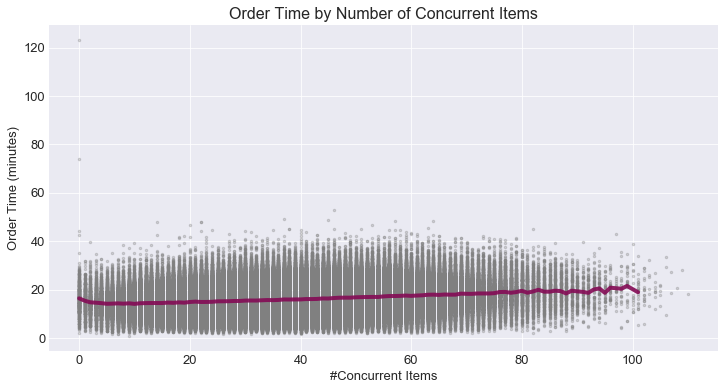

In [18]:
#Order Time by Total Item
plt.style.use('seaborn-dark')
plt.figure(figsize=(12,6))
plt.scatter(order['TotalItem'], order['OrderTime-Min'],s=6,alpha=0.3,color='grey')
d = order.groupby(['TotalItem']).agg({'OrderTime-Min':['mean','count']}).reset_index()
d = d[d['OrderTime-Min','count']>20]
plt.plot(d['TotalItem'],d[('OrderTime-Min','mean')],linewidth=4,alpha = 0.9,color='#840b55')
#plt.plot(order.groupby(['TotalItem'])['OrderTime-Min'].mean(),linewidth=4,alpha = 0.9,color='#840b55')
plt.title('Order Time by Number of Concurrent Items',family='sans-serif',fontsize=16)
plt.ylabel('Order Time (minutes)',family='sans-serif',fontsize=13)
plt.xlabel('#Concurrent Items',fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid()

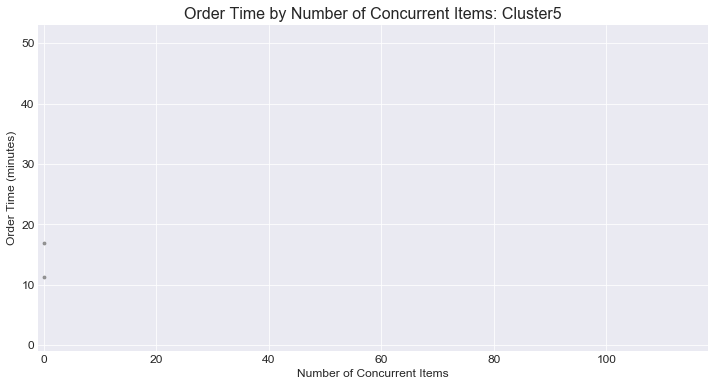

In [19]:
#Order Time by Total Item during the Busiest Time
c=5
plt.style.use('seaborn-dark')
plt.figure(figsize=(12,6))
plt.scatter(order[order['Class']==c]['TotalItem'], order[order['Class']==c]['OrderTime-Min'],s=8,alpha=0.8,color='grey')
d = order[order['Class']==c].groupby(['TotalItem']).agg({'OrderTime-Min':['mean','count']}).reset_index()
d = d[d['OrderTime-Min','count']>14]
plt.plot(d['TotalItem'],d[('OrderTime-Min','mean')],linewidth=4,alpha = 0.9,color='#840b55')
#plt.plot(order[order['Class']==c].groupby(['TotalItem'])['OrderTime-Min'].mean(),linewidth=4,alpha = 0.9,color='#840b55')
plt.title('Order Time by Number of Concurrent Items: Cluster'+str(c),family='sans-serif',fontsize=16)
plt.ylabel('Order Time (minutes)',family='sans-serif',fontsize=12)
plt.xlabel('Number of Concurrent Items',fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(-1,118)
plt.ylim(-1,53)
plt.grid()

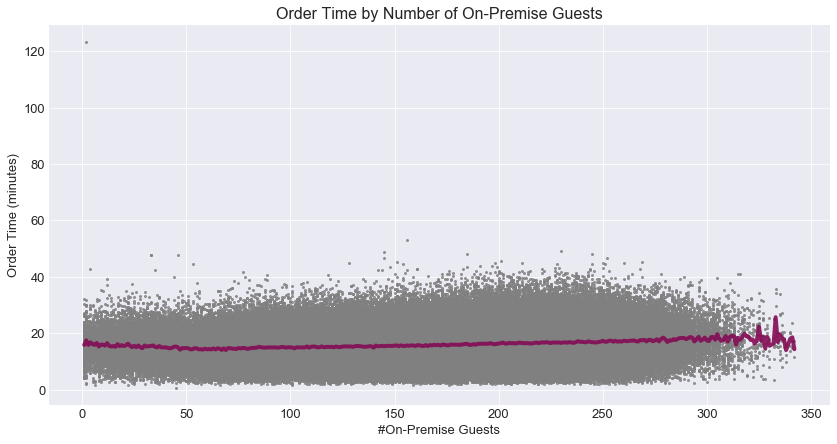

In [20]:
#Order Time by Total Guest
plt.style.use('seaborn-dark')
plt.figure(figsize=(14,7))
plt.scatter(order[order['OnSiteGuest']>0]['OnSiteGuest'], order[order['OnSiteGuest']>0]['OrderTime-Min'],s=4,alpha=0.8,color='grey')
plt.plot(order[order['OnSiteGuest']>0].groupby(['OnSiteGuest'])['OrderTime-Min'].mean(),linewidth=4,alpha = 0.9,color='#840b55')
plt.title('Order Time by Number of On-Premise Guests',family='sans-serif',fontsize=16)
plt.ylabel('Order Time (minutes)',family='sans-serif',fontsize=13)
plt.xlabel('#On-Premise Guests',fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid()

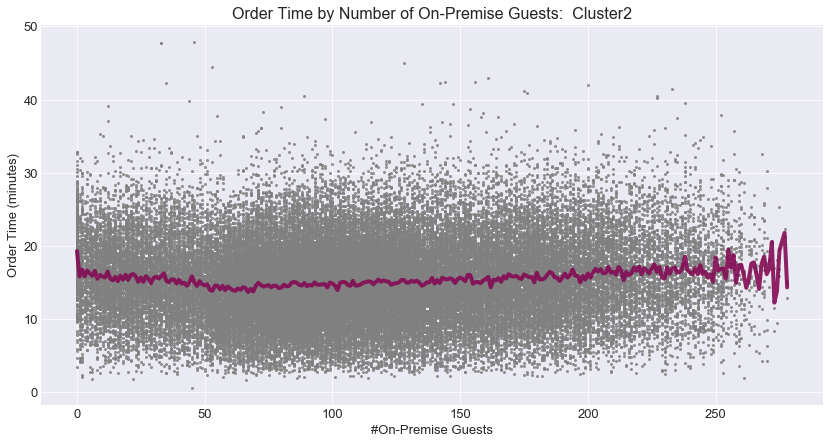

In [21]:
#Order Time by Total Guest
c = 2
plt.style.use('seaborn-dark')
plt.figure(figsize=(14,7))
plt.scatter(order[(order['Class']==c)]['OnSiteGuest'], order[(order['Class']==c)]['OrderTime-Min'],s=4,alpha=0.8,color='grey')
plt.plot(order[(order['Class']==c)].groupby(['OnSiteGuest'])['OrderTime-Min'].mean(),linewidth=4,alpha = 0.9,color='#840b55')
plt.title('Order Time by Number of On-Premise Guests:  Cluster'+str(c),family='sans-serif',fontsize=16)
plt.ylabel('Order Time (minutes)',family='sans-serif',fontsize=13)
plt.xlabel('#On-Premise Guests',fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid()

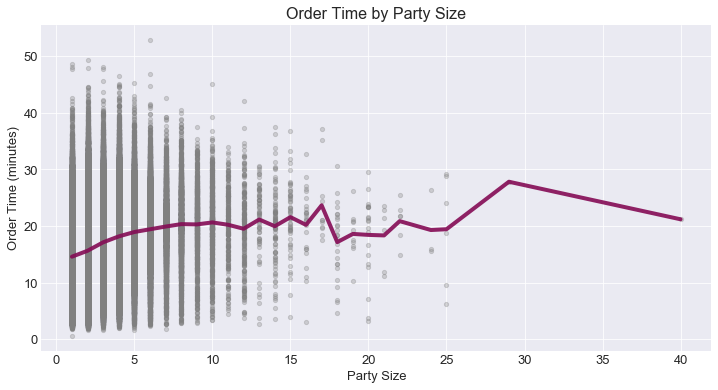

In [22]:
#Order Time by Number of Guest
plt.style.use('seaborn-dark')
plt.figure(figsize=(12,6))
plt.scatter(order['GuestCount'], order['OrderTime-Min'],s=18,alpha=0.3,color='grey')
plt.plot(order[order['OnSiteGuest']>0].groupby(['GuestCount'])['OrderTime-Min'].mean(),linewidth=4,alpha = 0.9,color='#840b55')
plt.title('Order Time by Party Size',family='sans-serif',fontsize=16)
plt.ylabel('Order Time (minutes)',family='sans-serif',fontsize=13)
plt.xlabel('Party Size',fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid()

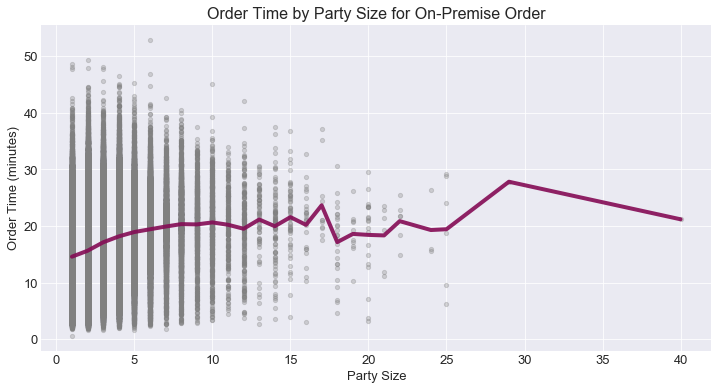

In [23]:
#Order Time by Number of Guest
plt.style.use('seaborn-dark')
plt.figure(figsize=(12,6))
plt.scatter(order[(order['ChannelName'].isin(['Patio','Dining Room','Bar','Bar Dining']))]['GuestCount'], order[order['ChannelName'].isin(['Patio','Dining Room','Bar','Bar Dining'])]['OrderTime-Min'],s=18,alpha=0.3,color='grey')
plt.plot(order[order['ChannelName'].isin(['Patio','Dining Room','Bar','Bar Dining'])].groupby(['GuestCount'])['OrderTime-Min'].mean(),linewidth=4,alpha = 0.9,color='#840b55')
plt.title('Order Time by Party Size for On-Premise Order',family='sans-serif',fontsize=16)
plt.ylabel('Order Time (minutes)',family='sans-serif',fontsize=13)
plt.xlabel('Party Size',fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid()


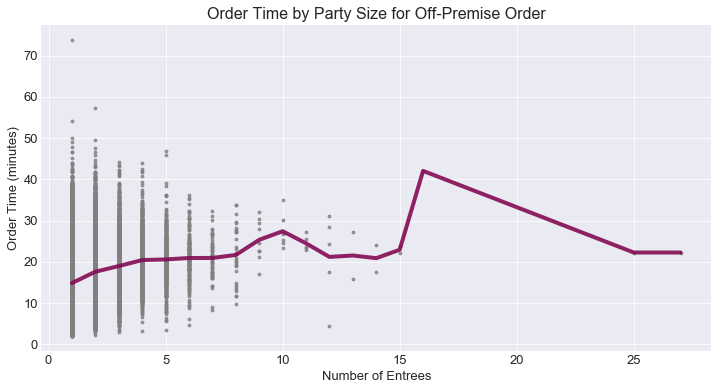

In [29]:
plt.style.use('seaborn-dark')
plt.figure(figsize=(12,6))
plt.scatter(order[(order['ChannelName'].isin(['Digital','To Go Sales','Delivery']))]['GuestCount'], order[order['ChannelName'].isin(['Digital','To Go Sales','Delivery'])]['OrderTime-Min'],s=8,alpha=0.8,color='grey')
plt.plot(order[order['ChannelName'].isin(['Digital','To Go Sales','Delivery'])].groupby(['GuestCount'])['OrderTime-Min'].mean(),linewidth=4,alpha = 0.9,color='#840b55')
plt.title('Order Time by Party Size for Off-Premise Order',family='sans-serif',fontsize=16)
plt.ylabel('Order Time (minutes)',family='sans-serif',fontsize=13)
plt.xlabel('Number of Entrees',fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid()


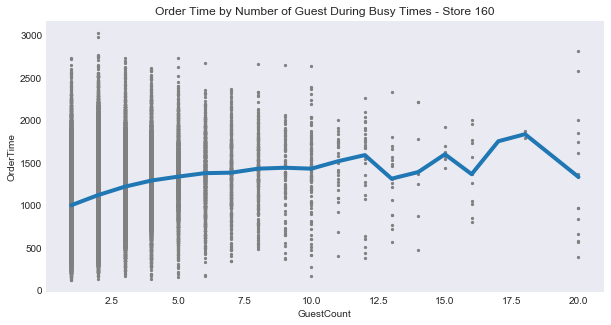

In [30]:
#Order Time by Number of Guest
c=0
order[order['Class']==c].plot(x='GuestCount', y='OrderTime', kind='scatter',figsize=(10,5),title='Order Time by Number of Guest During Busy Times - Store '+str(Store),c='grey',s=5)
order[order['Class']==c].groupby(['GuestCount'])['OrderTime'].agg(lambda x: np.percentile(x,q=50)).plot(linewidth=4)

In [31]:
#Based on previous visualizations, remove outliers
order = order[order['OrderTime-Min']<=50]

In [32]:
#Based on previous visualizations, remove outliers
order = order[order['GuestCount']<=25]

In [33]:
order.to_csv('Store'+str(Store)+'\Store'+str(Store)+'_order_15-min-cluster_20180103-20190711.csv') 

# Busy Times & Holidays

In [34]:
#Separate Order into holiday orders and non-holiday orders. 
order_holiday = order[order['Holiday']==1]
order_nonholiday = order[order['Holiday']==0]
order_holiday = order_holiday[(order_holiday['BusinessDate']>='2018-06-26')&(order_holiday['BusinessDate']<='2019-06-26')]

In [36]:
#Combining some holidays' names
order_holiday['NatHolidayDesc'] = order_holiday['NatHolidayDesc'].str.slice(0,-7)
order_holiday['NatHolidayDesc'] = np.where(order_holiday['NatHolidayDesc'].str.contains('New Years'),'New Year',order_holiday['NatHolidayDesc'])
order_holiday['NatHolidayDesc'] = np.where(order_holiday['NatHolidayDesc'].str.contains('Thanksgiving'),'Thanksgiving',order_holiday['NatHolidayDesc'])
order_holiday['NatHolidayDesc'] = np.where(order_holiday['NatHolidayDesc'].str.contains('Christmas'),'Christmas' ,order_holiday['NatHolidayDesc'])

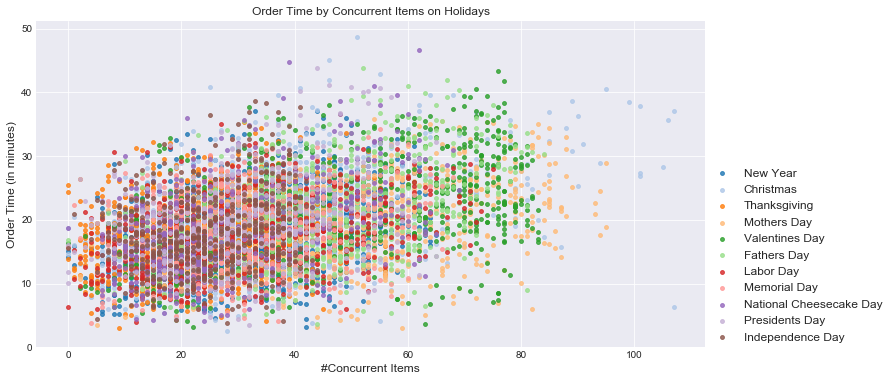

In [40]:
#Visualize Order Time by #Items on ALL holidays 
holiday = order_holiday['NatHolidayDesc'].value_counts().index
palatte = plt.get_cmap('tab20')
plt.style.use('seaborn-dark')
plt.figure(figsize=(12,6))
for i in range(len(holiday)):
    o = order_holiday[order_holiday['NatHolidayDesc']==holiday[i]]
    plt.scatter(o['TotalItem'], o['OrderTime-Min'],s=15,alpha=0.8,color=palatte(i),label=holiday[i])
plt.legend(loc=(1,0),fontsize=12)
plt.xlabel('#Concurrent Items',fontsize=12)
plt.ylabel('Order Time (in minutes)',fontsize=12)
plt.title('Order Time by Concurrent Items on Holidays')
plt.grid()

In [38]:
#Based on previous observations, separate holiday types
#order1: busy holidays, including Mothers Day, Christmans, Valentines Day, Fathers Day
order1 = order_holiday[order_holiday['NatHolidayDesc'].isin(['Mothers Day','Christmas','Valentines Day','Fathers Day'])==True]
order2 = order_holiday[order_holiday['NatHolidayDesc'].isin(['Mothers Day','Christmas','Valentines Day','Fathers Day'])==False]

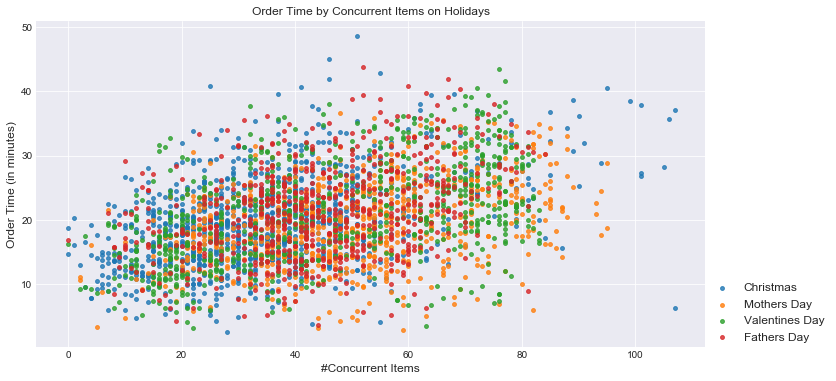

In [41]:
#Visualize Order TIme by #Items on BUSY holidays
holiday = order1['NatHolidayDesc'].value_counts().index
palatte = plt.get_cmap('tab10')
plt.style.use('seaborn-dark')
plt.figure(figsize=(12,6))
for i in range(len(holiday)):
    o = order1[order1['NatHolidayDesc']==holiday[i]]
    plt.scatter(o['TotalItem'], o['OrderTime-Min'],s=15,alpha=0.8,color=palatte(i),label=holiday[i])
plt.legend(loc=(1,0),fontsize=12)
plt.xlabel('#Concurrent Items',fontsize=12)
plt.ylabel('Order Time (in minutes)',fontsize=12)
plt.title('Order Time by Concurrent Items on Holidays')
plt.grid()

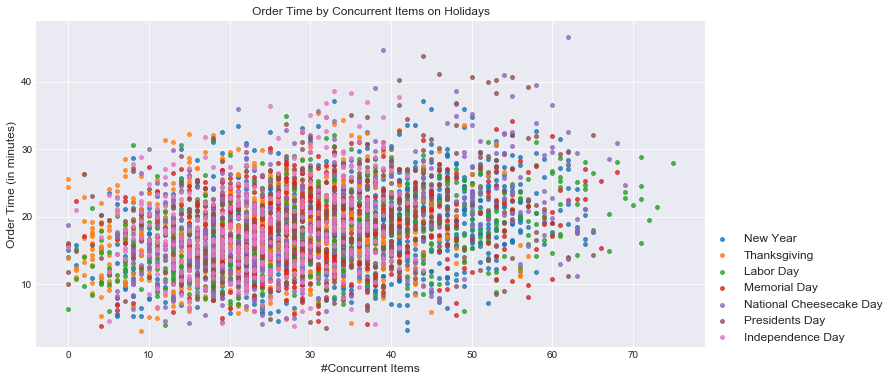

In [42]:
#Visualize Order TIme by #Items on other holidays
holiday = order2['NatHolidayDesc'].value_counts().index
palatte = plt.get_cmap('tab10')
plt.style.use('seaborn-dark')
plt.figure(figsize=(12,6))
for i in range(len(holiday)):
    o = order2[order2['NatHolidayDesc']==holiday[i]]
    plt.scatter(o['TotalItem'], o['OrderTime-Min'],s=15,alpha=0.8,color=palatte(i),label=holiday[i])
plt.legend(loc=(1,0),fontsize=12)
plt.xlabel('#Concurrent Items',fontsize=12)
plt.ylabel('Order Time (in minutes)',fontsize=12)
plt.title('Order Time by Concurrent Items on Holidays')
plt.grid()

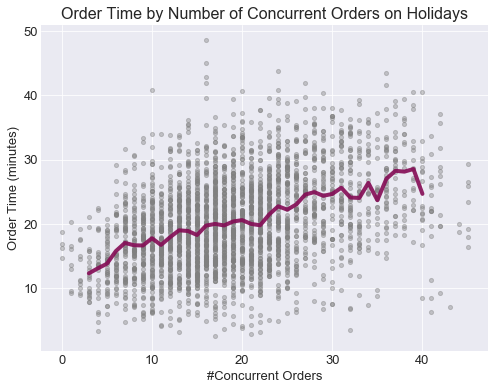

In [43]:
#Order Time by Total Order
plt.style.use('seaborn-dark')
plt.figure(figsize=(8,6))
plt.scatter(order1['TotalOrder'], order1['OrderTime-Min'],s=17,alpha=0.4,color='grey')
d = order1.groupby(['TotalOrder']).agg({'OrderTime-Min':['mean','count']}).reset_index()
d = d[d['OrderTime-Min','count']>15]
plt.plot(d['TotalOrder'],d[('OrderTime-Min','mean')],linewidth=4,alpha = 0.9,color='#840b55')
#plt.plot(order.groupby(['TotalOrder'])['OrderTime-Min'].median(),linewidth=4,alpha = 0.9,color='#840b55')
plt.title('Order Time by Number of Concurrent Orders on Holidays',family='sans-serif',fontsize=16)
plt.ylabel('Order Time (minutes)',family='sans-serif',fontsize=13)
plt.xlabel('#Concurrent Orders',fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid()

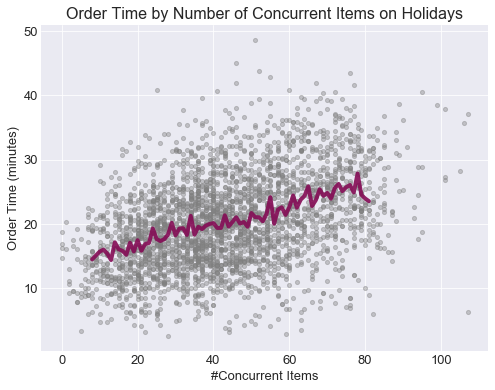

In [44]:
#Order Time by Total Order
plt.style.use('seaborn-dark')
plt.figure(figsize=(8,6))
plt.scatter(order1['TotalItem'], order1['OrderTime-Min'],s=17,alpha=0.4,color='grey')
d = order1.groupby(['TotalItem']).agg({'OrderTime-Min':['mean','count']}).reset_index()
d = d[d['OrderTime-Min','count']>15]
plt.plot(d['TotalItem'],d[('OrderTime-Min','mean')],linewidth=4,alpha = 0.9,color='#840b55')
#plt.plot(order.groupby(['TotalOrder'])['OrderTime-Min'].median(),linewidth=4,alpha = 0.9,color='#840b55')
plt.title('Order Time by Number of Concurrent Items on Holidays',family='sans-serif',fontsize=16)
plt.ylabel('Order Time (minutes)',family='sans-serif',fontsize=13)
plt.xlabel('#Concurrent Items',fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid()

(0, 60)

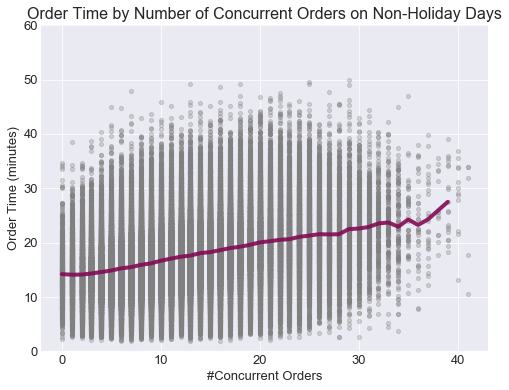

In [45]:
#Order Time by Total Order
plt.style.use('seaborn-dark')
plt.figure(figsize=(8,6))
plt.scatter(order_nonholiday['TotalOrder'], order_nonholiday['OrderTime-Min'],s=17,alpha=0.3,color='grey')
d = order_nonholiday.groupby(['TotalOrder']).agg({'OrderTime-Min':['mean','count']}).reset_index()
d = d[d['OrderTime-Min','count']>15]
plt.plot(d['TotalOrder'],d[('OrderTime-Min','mean')],linewidth=4,alpha = 0.9,color='#840b55')
#plt.plot(order.groupby(['TotalOrder'])['OrderTime-Min'].median(),linewidth=4,alpha = 0.9,color='#840b55')
plt.title('Order Time by Number of Concurrent Orders on Non-Holiday Days',family='sans-serif',fontsize=16)
plt.ylabel('Order Time (minutes)',family='sans-serif',fontsize=13)
plt.xlabel('#Concurrent Orders',fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid()
plt.ylim(0,60)

(-1, 62)

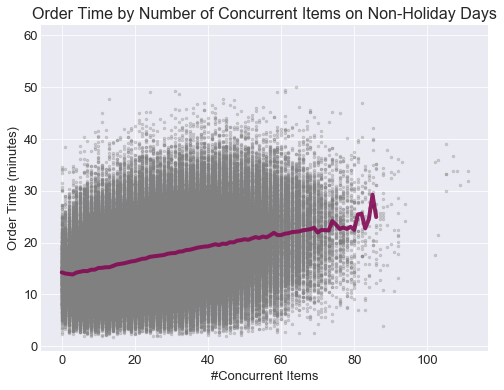

In [46]:
#Order Time by Total Item
plt.style.use('seaborn-dark')
plt.figure(figsize=(8,6))
plt.scatter(order_nonholiday['TotalItem'], order_nonholiday['OrderTime-Min'],s=6,alpha=0.3,color='grey')
d = order_nonholiday.groupby(['TotalItem']).agg({'OrderTime-Min':['mean','count']}).reset_index()
d = d[d['OrderTime-Min','count']>15]
plt.plot(d['TotalItem'],d[('OrderTime-Min','mean')],linewidth=4,alpha = 0.9,color='#840b55')
#plt.plot(order.groupby(['TotalItem'])['OrderTime-Min'].mean(),linewidth=4,alpha = 0.9,color='#840b55')
plt.title('Order Time by Number of Concurrent Items on Non-Holiday Days',family='sans-serif',fontsize=16)
plt.ylabel('Order Time (minutes)',family='sans-serif',fontsize=13)
plt.xlabel('#Concurrent Items',fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid()
plt.ylim(-1,62)